In [ ]:
!apt-get update

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [53.1 kB]
Hit:13 http://ppa.launchpad.net/cran/

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark


import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [ ]:
import math
import random
import numpy as np
from datetime import datetime
from pprint import pprint as p
import matplotlib.pyplot as plt

In [ ]:
import findspark
findspark.init()

In [ ]:
# Make a SparkSession
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext('local[*]')
spark = SparkSession(sc)

In [ ]:
dataframe2 = spark.read.format('csv').option("header","true").option("mode","DROPMALFORMED").load("coordinates.csv")

In [ ]:
type(dataframe2)

pyspark.sql.dataframe.DataFrame

In [ ]:
dataframe2.head()

Row(0.543121='0.616614',  0.435351=' 0.246787')

In [ ]:
dataset = dataframe2.toPandas().values.astype(np.float)

In [ ]:
class Canopy:
    def __init__(self, dataset):
        self.dataset = dataset
        self.t1 = 0
        self.t2 = 0
    
        # Set initial threshold
    def setThreshold(self, t1, t2):
        if t1 > t2:
            self.t1 = t1
            self.t2 = t2
        else:
            print('t1 needs to be larger than t2!')

    # Use Euclidean distance for distance calculation
    def euclideanDistance(self, vec1, vec2):
        return math.sqrt(((vec1 - vec2)**2).sum())
    
    # Randomly select a subscript according to the length of the current dataset
    def getRandIndex(self):
        return random.randint(0, len(self.dataset) - 1)
    
    def clustering(self):
        if self.t1 == 0:
            print('Please set the threshold.')
        else:
            canopies = []  # Used to store the final classification results
            while len(self.dataset) != 0:
                rand_index = self.getRandIndex()
                current_center = self.dataset[rand_index]  # Get a random center point and set it as P point
                current_center_list = []  # Initialize the canopy container of point P
                delete_list = []  # Initialize P point delete container
                self.dataset = np.delete(
                    self.dataset, rand_index, 0)  # Delete the randomly selected center point P
                for datum_j in range(len(self.dataset)):
                    datum = self.dataset[datum_j]
                    distance = self.euclideanDistance(
                        current_center, datum)  # Calculate the distance between the selected center point P and each point
                    if distance < self.t1:
                        # If the distance is less than t1, the point is classified into the canopy category of point P
                        current_center_list.append(datum)
                    if distance < self.t2:
                        delete_list.append(datum_j)  # If less than t2, it will be included in the delete container
                # Delete the element from the data set according to the subscript of the delete container
                self.dataset = np.delete(self.dataset, delete_list, 0)
                canopies.append((current_center, current_center_list))
        return canopies

In [ ]:
def main():
    t1 = 0.6
    t2 = 0.4
    gc = Canopy(dataset)
    gc.setThreshold(t1, t2)
    canopies = gc.clustering()
    print('Get %s initial centers.' % len(canopies))
    showCanopy(canopies, dataset, t1, t2)

In [ ]:
def showCanopy(canopies, dataset, t1, t2):
    fig = plt.figure()
    sc = fig.add_subplot(111)
    colors = ['brown', 'green', 'blue', 'y', 'r', 'tan', 'dodgerblue', 'deeppink', 'orangered', 'peru', 'blue', 'y', 'r',
              'gold', 'dimgray', 'darkorange', 'peru', 'blue', 'y', 'r', 'cyan', 'tan', 'orchid', 'peru', 'blue', 'y', 'r', 'sienna']
    markers = ['*', 'h', 'H', '+', 'o', '1', '2', '3', ',', 'v', 'H', '+', '1', '2', '^',
               '<', '>', '.', '4', 'H', '+', '1', '2', 's', 'p', 'x', 'D', 'd', '|', '_']
    for i in range(len(canopies)):
        canopy = canopies[i]
        center = canopy[0]
        components = canopy[1]
        sc.plot(center[0], center[1], marker=markers[i],
                color=colors[i], markersize=10)
        t1_circle = plt.Circle(
            xy=(center[0], center[1]), radius=t1, color='dodgerblue', fill=False)
        t2_circle = plt.Circle(
            xy=(center[0], center[1]), radius=t2, color='skyblue', alpha=0.2)
        sc.add_artist(t1_circle)
        sc.add_artist(t2_circle)
        for component in components:
            sc.plot(component[0], component[1],
                    marker=markers[i], color=colors[i], markersize=1.5)
    maxvalue = np.amax(dataset)
    minvalue = np.amin(dataset)
    plt.xlim(minvalue - t1, maxvalue + t1)
    plt.ylim(minvalue - t1, maxvalue + t1)
    plt.show()

Get 6 initial centers.


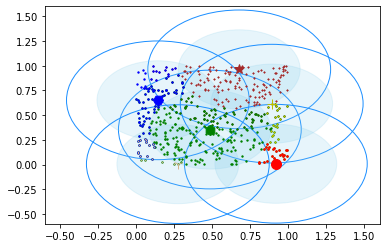

In [ ]:
main()